In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

(0.5, 1.0)

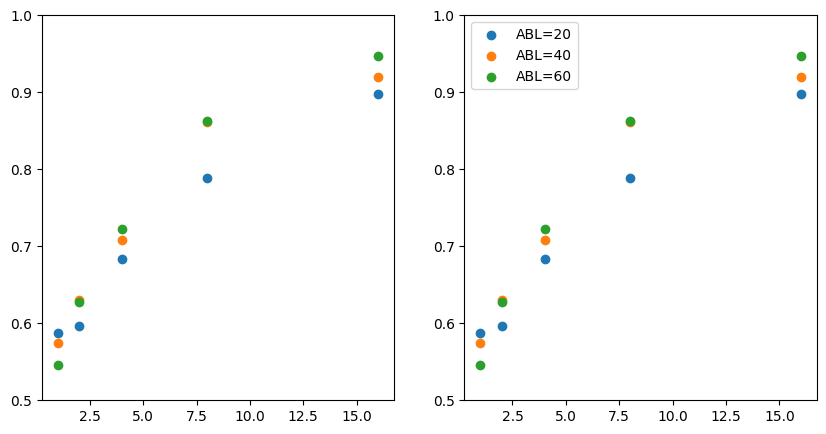

In [13]:
og_df = pd.read_csv('../out_LED.csv')

# chose non repeat trials - 0 or 2 or missing
df = og_df[ og_df['repeat_trial'].isin([0,2]) | og_df['repeat_trial'].isna() ]

# only session type 7
session_type = 7    
df = df[ df['session_type'].isin([session_type]) ]

# training level 16
training_level = 16
df = df[ df['training_level'].isin([training_level]) ]

# 1 is right , -1 is left
df['choice'] = df['response_poke'].apply(lambda x: 1 if x == 3 else (-1 if x == 2 else random.choice([1, -1])))

# 1 or 0 if the choice was correct or not
df['correct'] = (df['ILD'] * df['choice']).apply(lambda x: 1 if x > 0 else 0)

df_led_off = df[df['LED_trial'] == 0]
df_led_on = df[df['LED_trial'] == 1]

# Bilateral, Left and right same power = 100
df_led_on = df_led_on[df_led_on['LED_powerL'] == df_led_on['LED_powerR']]

df_led_on_small_aborts_cleaned = df_led_on[ ~((df_led_on['timed_fix'] < df_led_on['intended_fix']) & (df_led_on['timed_fix'] < 0.3)) ]

data_df = df_led_on_small_aborts_cleaned.copy()
data_df = data_df[ data_df['timed_fix'] - data_df['intended_fix'] < 1 ]

data_df = data_df.rename(columns={'timed_fix': 'rt', 'intended_fix': 't_stim'})
data_df = data_df[data_df['rt'] > data_df['t_stim']]
df = data_df.copy()

df['abs_ILD'] = np.abs(df['ILD'])

prob_correct_dict = {}

all_ABL = np.sort(df['ABL'].unique())
all_abs_ILD = np.sort(df['abs_ILD'].unique())

for abl in all_ABL:
    filtered_df = df[df['ABL'] == abl]
    prob_correct_dict[abl] = [
        filtered_df[filtered_df['abs_ILD'] == abs_ILD]['correct'].mean()
        for abs_ILD in all_abs_ILD
    ]

plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
for ABL in all_ABL:
    plt.scatter(all_abs_ILD, prob_correct_dict[ABL], label=f'ABL={ABL}')

plt.ylim(0.5, 1)
plt.subplot(1,2,2)
from diagnostics_class import Diagnostics
data_df = df_led_on_small_aborts_cleaned.copy()
data_df = data_df[ data_df['timed_fix'] - data_df['intended_fix'] < 1 ]
data_df = data_df.rename(columns={'timed_fix': 'rt', 'intended_fix': 't_stim'})
data_df_valid = data_df[ data_df['rt'] > data_df['t_stim'] ]
data_diagnose_obj_valid = Diagnostics(data_df_valid)

data_psycho = data_diagnose_obj_valid.plot_correct_vs_abs_ILD()
all_ABL = data_psycho.keys()
all_ILD = np.sort(df['ILD'].unique())
all_pos_ILD = list(set(np.abs(df['ILD'].unique())))

for ABL in all_ABL:
    plt.scatter(all_pos_ILD, data_psycho[ABL], label=f'ABL={ABL}')



plt.legend()
plt.ylim(0.5, 1)
